In [1]:
import torch
import torch.nn as nn
import PIL.Image
import io
import numpy as np
import datasets
from torchvision.transforms.v2 import CenterCrop, PILToTensor, ToPILImage, Pad, CenterCrop
from types import SimpleNamespace
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [2]:
device = "cuda"
# kodak = datasets.load_dataset("danjacobellis/kodak", split='validation')
# lsdir = datasets.load_dataset("danjacobellis/LSDIR_val", split='validation')
inet = datasets.load_dataset("timm/imagenet-1k-wds",split='validation')

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

In [3]:
checkpoint = torch.load('../hf/dance/LF_rgb_f16c12_v1.9_finetune3.pth', map_location=device,weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']

model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J=int(config.F**0.5),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode=config.lightweight_encode,
    lightweight_decode=config.lightweight_decode,
).to(device)
model.load_state_dict(state_dict)
model.eval();

21.158 KB
197.46289819453634x compression ratio
64.0x dimension reduction
35.15241773096761 dB PSNR


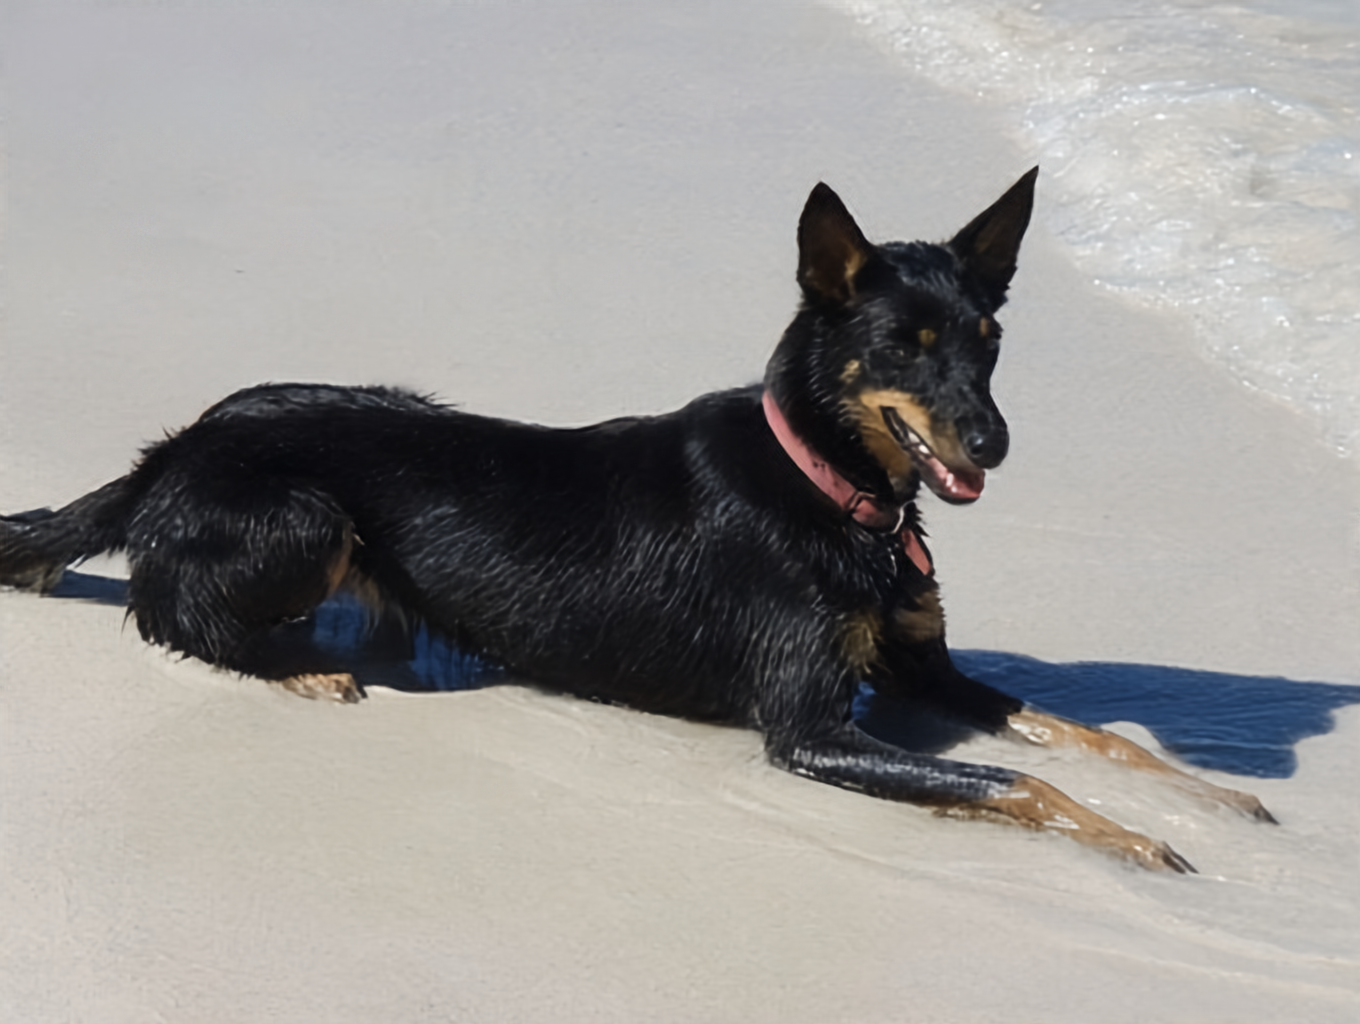

In [28]:
# img = lsdir[28]['image'].crop((512+256,512,1024+256,1024)).resize((768,768),resample=PIL.Image.Resampling.LANCZOS)
# img = kodak[22]['image'].crop((0,0,512,512))
img = inet[2]['jpg']
aspect = img.width/img.height
img = img.resize((int(16*(1024*aspect//16)),1024),resample=PIL.Image.Resampling.LANCZOS)
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)

buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")

latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)
    x_hat = x_hat.clamp(-1,1)

mse = torch.nn.functional.mse_loss(x_orig, x_hat[0])
PSNR = -10 * mse.log10().item() + 20*np.log10(2)
print(f"{PSNR} dB PSNR")

# display(ToPILImage()(x_orig.clamp(-1, 1) / 2 + 0.5))  # Original image
# display(webp[0])  # Compressed WEBP image
display(ToPILImage()(x_hat[0].clamp(-1, 1) / 2 + 0.5))  # Reconstructed image

In [5]:
# buff = io.BytesIO()
# img.save(buff, format='JPEG', quality=0, subsampling=2)
# size_bytes = len(buff.getbuffer())
# print(f"{size_bytes/1e3} KB")
# print(f"{orig_dim/size_bytes}x compression ratio")
# buff.seek(0)
# webp = PIL.Image.open(buff)
# MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
# print(f"{-10*MSE.log10()} PSNR")
# display(webp)

In [6]:
# import matplotlib.pyplot as plt
# plt.hist(latent.flatten().cpu(),bins=255, range=(-127.5,127.5),width=0.9,density=True);
# plt.xlim([-15,15])

# def entropy_bits(x):
#     unique_values, counts = torch.unique(x, return_counts=True)
#     p = counts.float() / x.numel()
#     return -torch.sum(p * torch.log2(p))

# 64*(8/entropy_bits(latent))

In [7]:
# buff = io.BytesIO()
# img.save(buff, format='JPEG2000', quality_layers=[500])
# size_bytes = len(buff.getbuffer())
# print(f"{size_bytes/1e3} KB")
# print(f"{orig_dim/size_bytes}x compression ratio")
# buff.seek(0)
# webp = PIL.Image.open(buff)
# MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
# print(f"{-10*MSE.log10()} PSNR")
# display(webp)

In [35]:
import io
import time
import torch
import numpy as np
from PIL import Image as PILImage
from torchvision.transforms import Pad, CenterCrop, PILToTensor
from datasets import Dataset
from piq import LPIPS, DISTS, SSIMLoss

# Initialize LPIPS and DISTS on GPU for faster computation
lpips_loss = LPIPS().to(device)
dists_loss = DISTS().to(device)
ssim_loss = SSIMLoss().to(device)

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
def compress_and_evaluate(sample):
    img = sample['jpg'].convert("RGB")
    aspect = img.width/img.height
    img = img.resize((int(16*(1024*aspect//16)),1024),resample=PIL.Image.Resampling.LANCZOS)
    x_orig = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
    orig_dim = x_orig.numel() 

    t0 = time.time()
    with torch.no_grad():
        z = model.encode(x_orig)
        latent = model.quantize.compand(z).round()
    webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
    buff = io.BytesIO()
    webp[0].save(buff, format='WEBP', lossless=True)
    encode_time = time.time() - t0
    size_bytes = len(buff.getbuffer())
    t0 = time.time()
    latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
    with torch.no_grad():
        x_hat = model.decode(latent_decoded).clamp(-1,1)
    decode_time = time.time() - t0

    x_orig_01 = x_orig / 2 + 0.5
    x_hat_01 = x_hat / 2 + 0.5
    
    mse = torch.nn.functional.mse_loss(x_orig_01[0], x_hat_01[0])
    PSNR = -10 * mse.log10().item()
    bpp = 8 * size_bytes / (img.width * img.height)
    LPIPS_dB = -10 * np.log10(lpips_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())
    DISTS_dB = -10 * np.log10(dists_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())
    SSIM = 1 - ssim_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item()

    return {
        'bpp': bpp,
        'PSNR': PSNR,
        'LPIPS_dB': LPIPS_dB,
        'DISTS_dB': DISTS_dB,
        'SSIM': SSIM,
        'encode_time': encode_time,
        'decode_time': decode_time,
    }

metrics = [
    'bpp',
    'PSNR',
    'LPIPS_dB',
    'DISTS_dB',
    'SSIM',
    'encode_time',
    'decode_time',
]

In [46]:
results_dataset = inet.select(range(100)).map(compress_and_evaluate)

print("mean\n---")
for metric in metrics:
    μ = np.mean(results_dataset[metric])
    print(f"{metric}: {μ}")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

mean
---
bpp: 0.1464885237051854
PSNR: 31.02140164375305
LPIPS_dB: 5.973984777683942
DISTS_dB: 11.844953597361137
SSIM: 0.9448417627811432
encode_time: 0.009113118648529053
decode_time: 0.004281978607177734
